<a href="https://colab.research.google.com/github/bmericskay/GeoPandas/blob/main/TransportDataGouv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Travailler avec les nouveaux schémas de données sur le vélo 🚴

📔 Ce **notebook** a comme objectif d'**automatiser la préparation et l'analyse de données de mobilités relatives au vélos** disponibles sur la plateforme https://transport.data.gouv.fr/.  
  
💾 Il s'appuie sur l'utilisation de deux de jeux de d**onnées standardisés selon les schémas nationaux** de https://schema.data.gouv.fr/, facilitant ainsi la **reproductibilité** des analyses entre territoires :

*   Les réseaux cyclables
*   Les équipements de stationnement cyclable  

  
🧰 Les fonctions utilisées ici s'articulent essentiellement autour des librairies suivantes:

*  📈 Pandas, numpy et matplolib
*  🧭 Geopandas, contextily






## Configuration environnement de travail

In [ ]:
#Initialisation de l'environnement avec geopandas
!apt update
!apt install gdal-bin python-gdal python3-gdal
# Install rtree - Geopandas requirment
!apt install python3-rtree
# Install Geopandas
! pip install geopandas
# Instal MatplotLib
! pip install matplotlib
# Instal contextily
!pip install contextily
#Depuis sa version 0.8, Geopandas peut fonctionner de manière expérimental avec Pygeos ce qui accèlère certaines opérations
!pip install pygeos
# Pour la cartographie thématique
!pip install mapclassify
# Pour la cartographie interactive
!pip install folium
# Pour l'affichage d'une échelle cartographique
!pip install matplotlib_scalebar

In [ ]:
#Importation des librairies nécessaires

import pandas as pd #Gestion de données
import matplotlib.pyplot as plt #Visualisation de données
import geopandas as gpd #Gestion données spatiales
import contextily as ctx #Fonds de carte
import numpy as np #Manipulation de tableaux
import shapely #Manipulation de géométrie
import folium #Cartographie interactive
import mapclassify #Cartographie thématique
from matplotlib_scalebar.scalebar import ScaleBar #Echelle cartographique

# Réseaux cyclables

Les jeux de données de cette catégorie décrivent les réseaux cyclables en France sous la forme de **Geojson**. Tous les aménagements (pistes, bandes, voies vertes, vélo rue…) destinés à être empuntés par des vélos peuvent être représentés selon le [schéma national](https://schema.data.gouv.fr/etalab/schema-amenagements-cyclables/latest.html).

Choisir un jeu de données disponible sur cette page : https://transport.data.gouv.fr/datasets?type=bike-way

## Importer les données



case comm      etat                                 ame_d  ame_g   ville  \
0   NaN       EXISTANT  DOUBLE SENS CYCLABLE NON MATERIALISE  AUCUN    Metz   
1   NaN       EXISTANT                            VOIE VERTE         Woippy   
2  True       EXISTANT                            VOIE VERTE  AUCUN  Woippy   

  id_osm           sens_d           sens_g source  ... largeur_d largeur_g  \
0         UNIDIRECTIONNEL  UNIDIRECTIONNEL    EMM  ...       NaN       NaN   
1          BIDIRECTIONNEL                      MM  ...       NaN       NaN   
2          BIDIRECTIONNEL                      MM  ...       3.0       NaN   

    project_c  adresse_ru code_com_d code_com_g  reseau_loc   revetement  \
0                                                     Autre                
1                                                     Autre  enrobé noir   
2  LAMBERT 93                                         Autre       enrobe   

  trafic_vit                                           geometry  
0        NaN  MULTILINESTRING ((6.17640 49.12043, 6.17685 49...  
1        NaN  MULTILINESTRING ((6.14705 49.15876, 6.14710 49...  
2        NaN  MULTILINESTRING ((6.14082 49.14667, 6.14147 49...  

[3 rows x 33 columns]

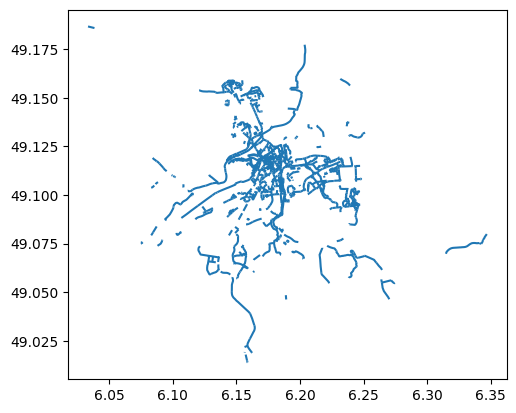

In [243]:
# Importer les données d'une ville

URL = "https://si.eurometropolemetz.eu/fiches/opendata/agd/amenagementcyclable_eurometropolemetz.geojson"
AC= gpd.read_file(URL, encoding='utf-8')
AC.plot()
AC.head(3)

## Explorer les données

### Graphiques des types d'équipements cyclcables

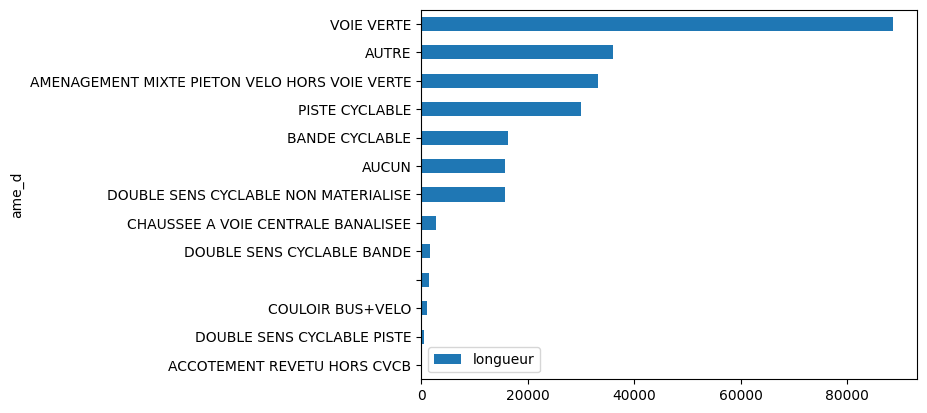

In [247]:
#Calculer la longueur des pistes cyclables par grand type et en faire un graphique

Longueurpistescyclables  = AC[["ame_d", "longueur"]].groupby("ame_d").sum()
Longueurpistescyclables =pd.DataFrame(Longueurpistescyclables)
Longueurpistescyclables = Longueurpistescyclables.sort_values("longueur", ascending=True)

# Graphique des types d'aménagement

ax = Longueurpistescyclables.plot(kind='barh', colormap='tab10')
plt.show()

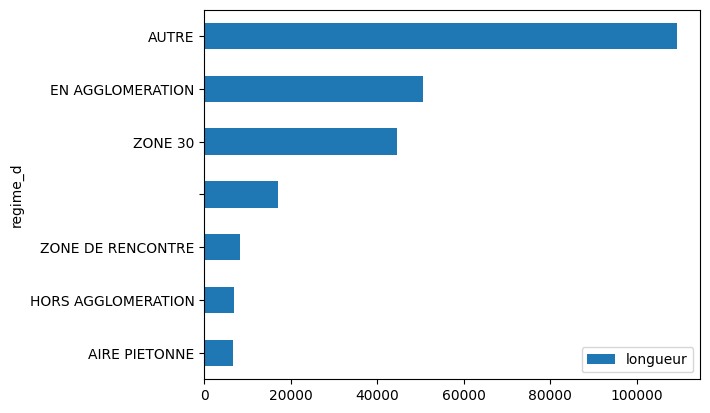

In [248]:
#Calculer la longueur des pistes cyclables par grand type et en faire un graphique

Regimespistescyclables  = AC[["regime_d", "longueur"]].groupby("regime_d").sum()
Regimespistescyclables =pd.DataFrame(Regimespistescyclables)
Regimespistescyclables = Regimespistescyclables.sort_values("longueur", ascending=True)

# Graphique des types d'aménagement

ax = Regimespistescyclables.plot(kind='barh', colormap='tab10')
plt.show()

### Cartographier les données

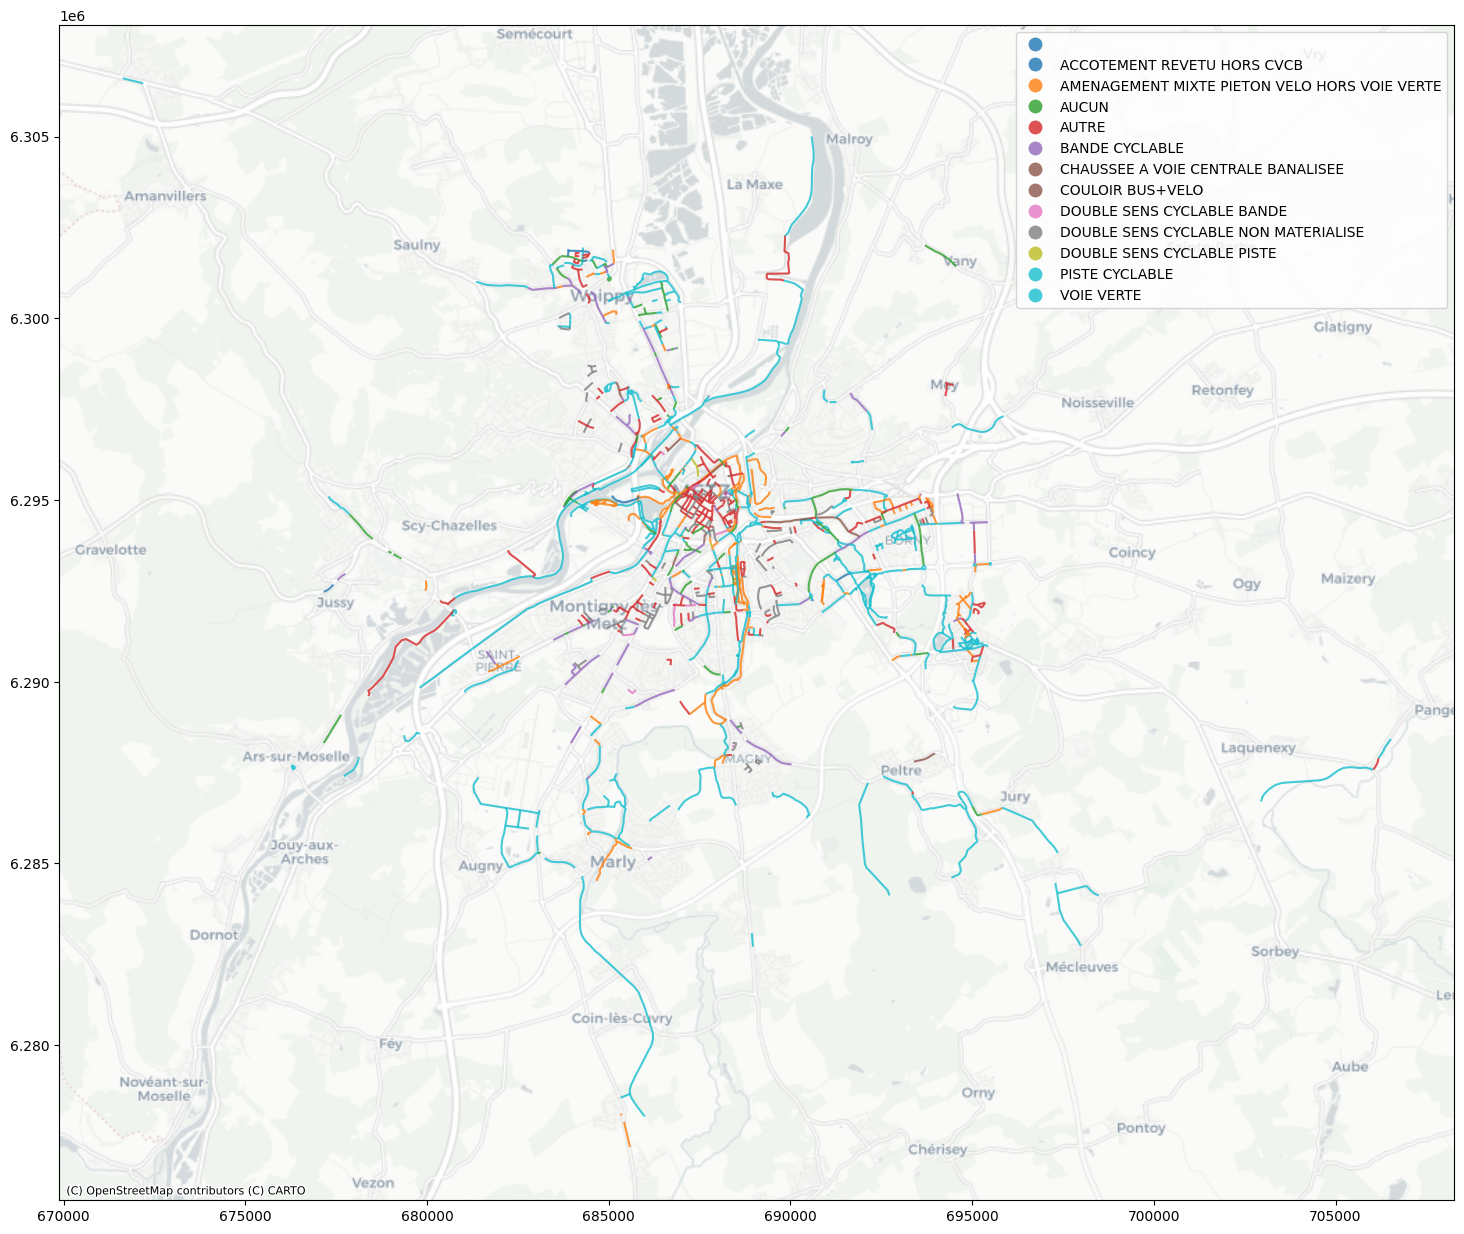

In [249]:
# Cartographier les aménagements cyclables

Carte1, ax = plt.subplots(figsize=(18,18))

AC.to_crs('EPSG:3857').plot(ax=ax, column="ame_d", cmap='tab10', alpha=0.8, categorical=True,legend=True, zorder=3)
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

## Analyse spatiale des données

### Calcul des longueurs des équipements sous formes de carroyages

(919935.6598415055, 945609.4376603378, 6882998.26817735, 6903744.227646968)

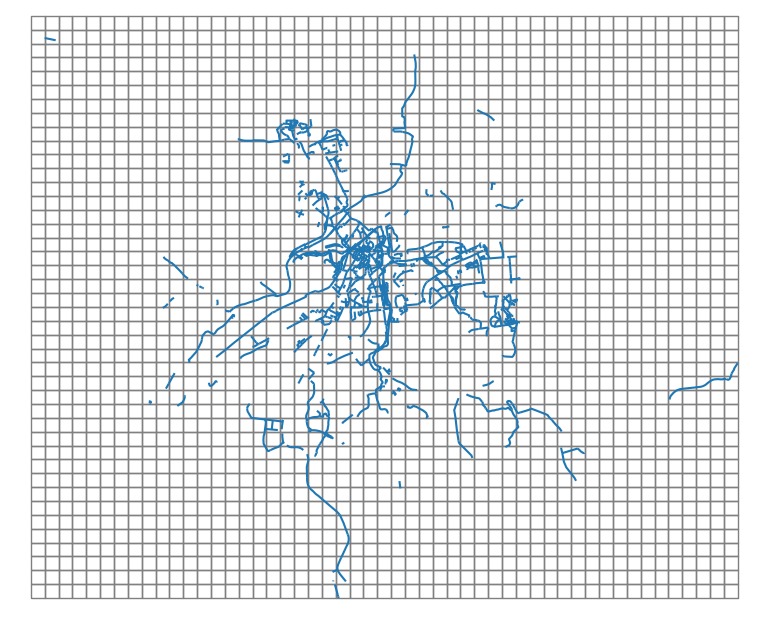

In [250]:
# Faire le carroyage

import shapely.geometry

AC = AC.to_crs(2154)

# Définir l'emprise de la grille
xmin, ymin, xmax, ymax= AC.total_bounds

# Paramètrer le nombre de cellule
n_cells=50
cell_size = (xmax-xmin)/n_cells

# Création des cellules
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                 crs='EPSG:2154')


# Cartographie pour contrôle
ax = AC.plot(markersize=1, figsize=(12, 8))
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")

In [251]:
# Jointure spatiale Pistes cyclables <> Carreaux

cell['id'] = cell.reset_index().index
pistescyclablesok = gpd.sjoin(AC, cell)

#Calculer la longueur des pistes cyclables par IRIS et en faire une carte

Longueurpistescyclables  = pistescyclablesok[["id", "longueur"]].groupby("id").sum()
Longueurpistescyclables =pd.DataFrame(Longueurpistescyclables)

# Faire la jointure attributaire

CarroAC = cell.merge(Longueurpistescyclables, left_on='id', right_on='id')
CarroAC.head()

geometry   id    longueur
0  POLYGON ((920635.854 6902613.105, 920635.854 6...   40  379.193536
1  POLYGON ((921102.650 6902613.105, 921102.650 6...   82  379.193536
2  POLYGON ((924370.221 6890476.410, 924370.221 6...  350  244.739505
3  POLYGON ((924837.017 6890943.206, 924837.017 6...  393  598.776298
4  POLYGON ((924837.017 6893277.186, 924837.017 6...  398  219.973861

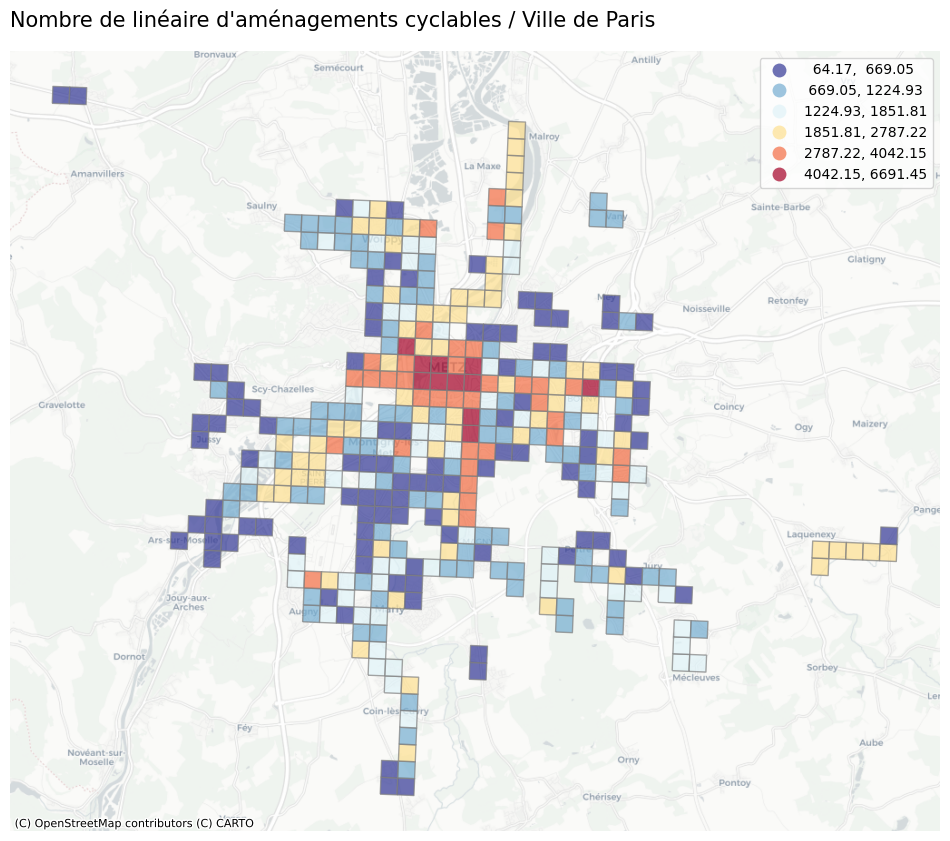

In [252]:
# Cartographie du carroyage

CarroyageVelos, ax = plt.subplots(figsize=(12,12))

CarroAC.to_crs('EPSG:3857').plot(ax=ax, column='longueur', figsize=(12, 8), k=6, cmap='RdYlBu_r', scheme='fisher_jenks', edgecolor="grey", alpha=0.7, legend = 'true')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.axis("off")
plt.title("Nombre de linéaire d'aménagements cyclables / Ville de Paris", loc='left', fontsize=15)

plt.show()

# Stationnements de vélos

Les jeux de données de cette catégorie décrivent les équipements de stationnement cyclable en France. Tous les équipements (arceaux, racks, box…) destinés à être utilisés pour stationner des vélos peuvent être représentés selon le schéma national.

Choisir un jeu de données disponible sur cette page : https://transport.data.gouv.fr/datasets?type=bike-parking

## Importer et préparer les données



In [253]:
#Importer les données d'une ville et préparer les coordonnées géographiques en deux colonnes

URL = "https://data.strasbourg.eu/explore/dataset/stationnementcyclable_ville_et_eurometropole_de_strasbourg/download?format=csv&timezone=Europe/Berlin&use_labels_for_header=false"
Stationnements = pd.read_csv(URL, sep=';')
Stationnements[['longitude', 'latitude']] = Stationnements['coordonneesxy'].str.strip('[]').str.split(',', expand=True).astype(float)
Stationnements.head()

id_local  id_osm  code_com         coordonneesxy  capacite  capacite_cargo  \
0     13129     NaN       NaN  [7.749361,48.580512]         5             NaN   
1     13163     NaN       NaN   [7.68762,48.558729]         3             NaN   
2     13128     NaN       NaN   [7.74971,48.580386]         2             NaN   
3     13142     NaN       NaN  [7.726858,48.574681]         2             NaN   
4     13191     NaN       NaN  [7.753105,48.603551]         4             NaN   

   type_accroche mobilier  acces  gratuit  ...  lumiere url_info  d_service  \
0  CADRE ET ROUE    AUTRE    NaN      NaN  ...      NaN      NaN        NaN   
1  CADRE ET ROUE    AUTRE    NaN      NaN  ...      NaN      NaN        NaN   
2  CADRE ET ROUE    AUTRE    NaN      NaN  ...      NaN      NaN        NaN   
3  CADRE ET ROUE    AUTRE    NaN      NaN  ...      NaN      NaN        NaN   
4  CADRE ET ROUE    AUTRE    NaN      NaN  ...      NaN      NaN        NaN   

                                 source  proprietaire   gestionnaire  \
0  Ville et eurométropole de Strasbourg           NaN  eurometropole   
1  Ville et eurométropole de Strasbourg           NaN          autre   
2  Ville et eurométropole de Strasbourg           NaN  eurometropole   
3  Ville et eurométropole de Strasbourg           NaN  eurometropole   
4  Ville et eurométropole de Strasbourg           NaN  eurometropole   

     date_maj  commentaires longitude   latitude  
0  2019-12-24           NaN  7.749361  48.580512  
1  2019-11-05           NaN  7.687620  48.558729  
2  2019-12-04           NaN  7.749710  48.580386  
3  2019-12-05           NaN  7.726858  48.574681  
4  2019-11-25           NaN  7.753105  48.603551  

[5 rows x 23 columns]

<Axes: >

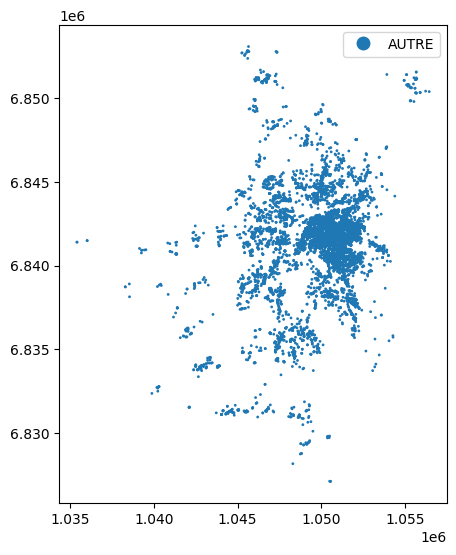

In [254]:
#Dataframe to GeoDataframe

StationnementsGeo = gpd.GeoDataFrame(Stationnements, crs = 'epsg:4326', geometry=gpd.points_from_xy(Stationnements.longitude, Stationnements.latitude))
StationnementsGeo = StationnementsGeo.to_crs(2154)
StationnementsGeo.plot(figsize=(5,10), markersize=1, column = "mobilier", legend = True)

## Explorer les données de stationnements vélos

### Graphiques des équipements

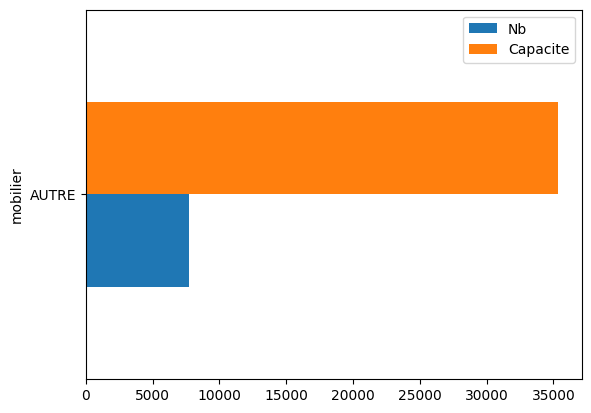

In [255]:
# Agrégation statistique

StatsStationnements = Stationnements.groupby("mobilier").agg(Nb=("id_local", "count"), Capacite=("capacite", "sum"))
StatsStationnements = StatsStationnements.sort_values("Capacite", ascending=True)

# Graphique des types de stationnements

ax = StatsStationnements.plot(kind='barh')
plt.show()

### Cartographie des équipements

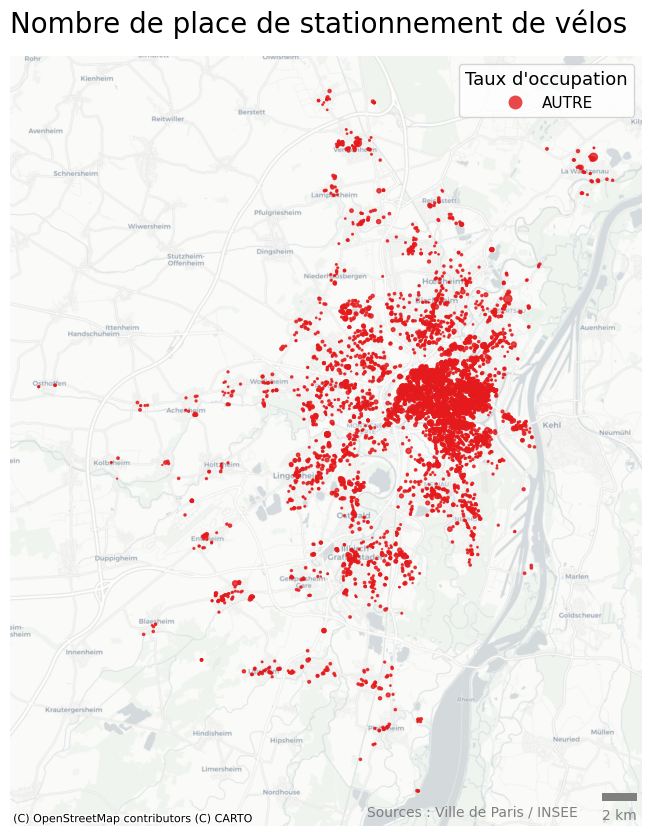

In [256]:
# Cartographier les aménagements cyclables

Carte1, ax = plt.subplots(figsize=(12,10))

StationnementsGeo.to_crs('EPSG:3857').plot(ax=ax, markersize=StationnementsGeo['capacite']*0.5,column="mobilier", cmap='Set1',alpha=0.8, categorical=True,
                                    legend=True, legend_kwds={'title': "Taux d'occupation", 'loc': 'upper right', 'title_fontsize':13, 'fontsize':11})

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

# On enlève les axes
ax.axis("off")

# Ajout du titre de la carte
plt.title("Nombre de place de stationnement de vélos", loc='left', fontsize=20)

# Ajout des sources
ax.text(0.90, 0.01, 'Sources : Ville de Paris / INSEE', verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='grey', fontsize=10)

#Ajout d'une échelle
ax.add_artist(ScaleBar(1, length_fraction=0.1, location = "lower right", box_alpha=0, color="grey"))

plt.show()

## Analyse spatiale des stationnements de vélos

### Carroyage de concentration des stationnements vélos

(1034357.0506864369, 1057489.1256999401, 6825816.669070875, 6854369.336517699)

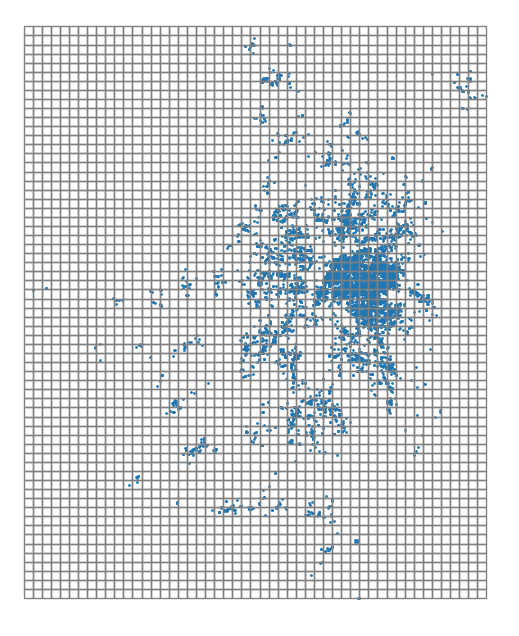

In [257]:
# Analyse spatiale de la concentration des aménagements cyclables

import shapely.geometry

# Définir l'emprise de la grille
xmin, ymin, xmax, ymax= StationnementsGeo.total_bounds

# Paramètrer le nombre de cellule
n_cells=50
cell_size = (xmax-xmin)/n_cells

# Création des cellules
grid_cells = []
for x0 in np.arange(xmin, xmax+cell_size, cell_size):
    for y0 in np.arange(ymin, ymax+cell_size, cell_size):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append(shapely.geometry.box(x0, y0, x1, y1)  )
cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'],
                                 crs='EPSG:2154')


# Cartographie pour contrôle
ax = StationnementsGeo.plot(markersize=1, figsize=(12, 8))
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")

In [258]:
# Jointure spatiale Stationnements <> Carroyage
cell['id'] = cell.reset_index().index
StationnementsCaroyage = gpd.sjoin(StationnementsGeo, cell)

#Calculer le nombre de place de stationnements par carreaux

StationnementCaroyage  = StationnementsCaroyage[["id", "capacite"]].groupby("id").sum()
StationnementCaroyage =pd.DataFrame(StationnementCaroyage)

# Faire la jointure attributaire

CarroStationnements = cell.merge(StationnementCaroyage, left_on='id', right_on='id')
CarroStationnements.head()

geometry   id  capacite
0  POLYGON ((1034987.925 6840993.763, 1034987.925...   33         3
1  POLYGON ((1035408.509 6840993.763, 1035408.509...   96         6
2  POLYGON ((1035829.092 6841414.346, 1035829.092...  160        10
3  POLYGON ((1037932.008 6838470.264, 1037932.008...  468         4
4  POLYGON ((1038352.591 6838049.680, 1038352.591...  530         1

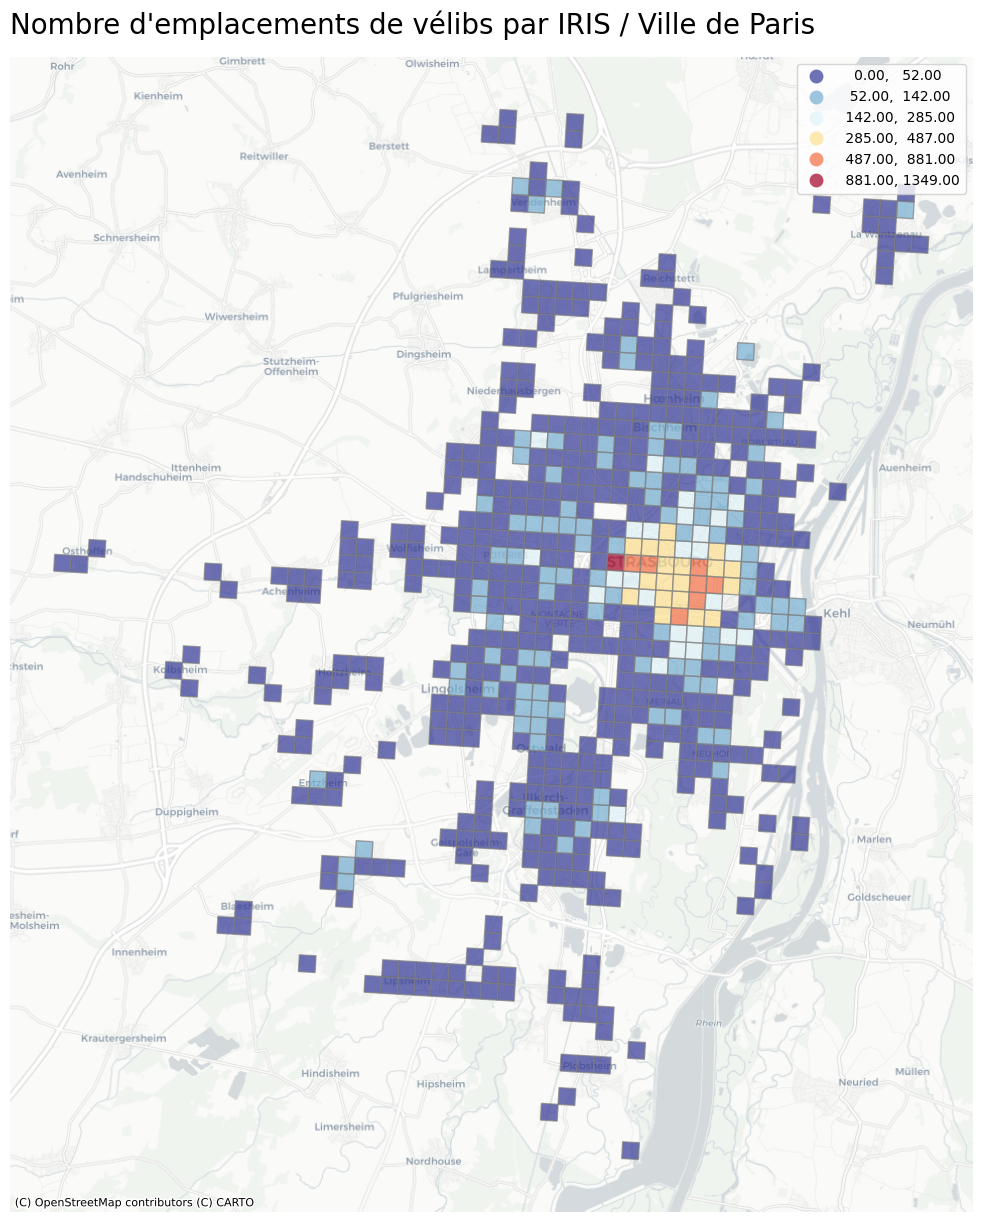

In [259]:
#Cartographie du carroyage

CarteStationnement, ax = plt.subplots(figsize=(15,15))

CarroStationnements.to_crs('EPSG:3857').plot(ax=ax, column='capacite', k=6, cmap='RdYlBu_r', scheme='fisher_jenks', edgecolor="grey", alpha=0.7, legend = 'true')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.axis("off")
plt.title("Nombre d'emplacements de vélibs par IRIS / Ville de Paris", loc='left', fontsize=20)

plt.show()

### Cartographie du nombre de stationnements vélos sous formes de cercles

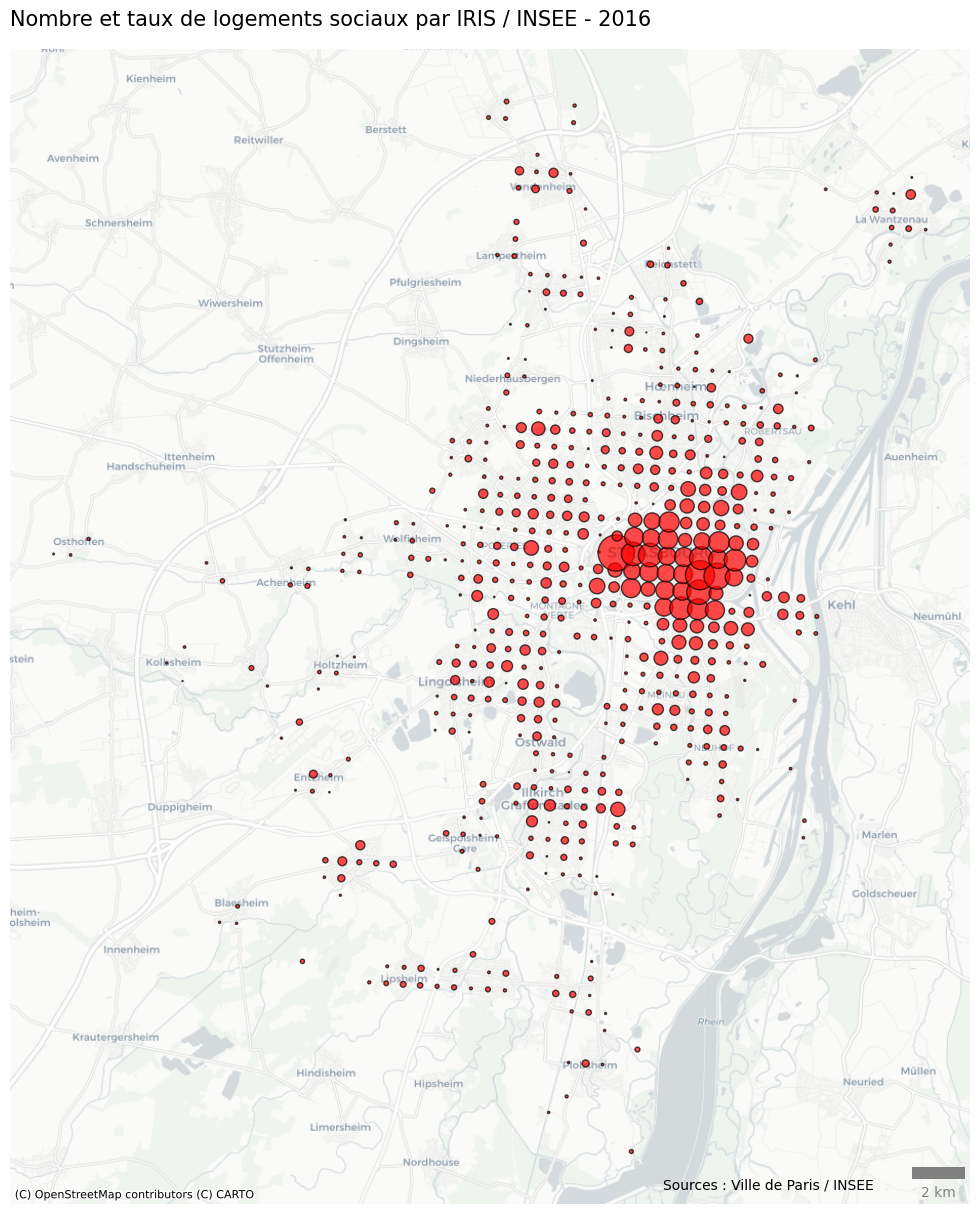

In [260]:
# Transformer le geodataframe (polygone) en points (centroides)
CarroStationnementscentro = CarroStationnements.copy()
CarroStationnementscentro.geometry = CarroStationnementscentro['geometry'].centroid


# Faire la carte

Carte5, ax = plt.subplots(figsize=(15,15))
CarroStationnementscentro.to_crs('EPSG:3857').plot(ax=ax, markersize=CarroStationnementscentro["capacite"]*0.5, alpha=0.7, color= "red", edgecolor="black", categorical=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

ax.axis("off")
plt.title('Nombre et taux de logements sociaux par IRIS / INSEE - 2016', loc='left', fontsize=15)
ax.text(0.90, 0.01, 'Sources : Ville de Paris / INSEE', verticalalignment='bottom', horizontalalignment='right',
        transform=ax.transAxes, color='black', fontsize=10)
ax.add_artist(ScaleBar(1, length_fraction=0.1, location = "lower right", box_alpha=0, color="grey"))

plt.show()